This Notebook is designed to perform Exploratory Data Analysis for both Synthetic Dataset & Farm Yield Dataset. IF you want to explore usage of other datasets, you can load them directly in this notebook or make appropriate changes in src/data_loaders.py

In [1]:
# Importing all the dependencies required

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler as stdscaler
from sklearn.model_selection import train_test_split as tts
import joblib

In [2]:
# This allows .py files defined in src to be used in notebooks
import os
import sys

src_path = os.path.abspath(os.path.join('..', 'src'))

if src_path not in sys.path:
    sys.path.append(src_path)
    
from data_loaders import data_loading_preprocessing


Firstly, The synthetic datasets are generated using functions defined in src/data_loaders.py. 
Follwed by performing EDA

In [3]:
# Generating the synthetic dataset 
# data_loading_preprocessing takes following input => 
#       type of data generated, number of samples, features, & informative features along with noise, multicollinearity_strength
syn_X, syn_y, true_beta = data_loading_preprocessing("synthetic", 100, 15, 7, 0.23, 0.6)

Generating Synthetic Dataset with 100 samples and 15 features.
Correlation Clusters Generation Successfully
Apply correlation to clusters generated successfully!!
Synthetic Data Generation Successful


In [4]:
# Coefficients
true_beta

array([-2.0055649 ,  0.        ,  3.01366916,  0.        ,  2.66588524,
        2.3361583 ,  0.        , -4.37457773,  0.        ,  2.35505606,
       -2.64142401, -1.28577998,  0.        ,  0.        ,  0.        ,
        0.        ])

In [5]:
# Removing Intercept from syn_X 
syn_X_1 = syn_X.copy().drop(['Intercept'], axis=1)
print(syn_X_1.head())

   Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
0   1.032080  -0.138264   0.997825   1.523030  -0.234153   0.468730   
1   0.086705  -1.012831  -0.174661  -0.908024  -1.412304   0.516180   
2   0.042334   1.852278  -0.431183  -1.057711   0.822545  -1.155591   
3   0.646509  -0.460639   0.771721   0.343618  -1.763040   0.331898   
4  -0.063148  -0.185659  -1.142284  -1.196207   0.812526   0.335261   

   Feature 7  Feature 8  Feature 9  Feature 10  Feature 11  Feature 12  \
0   1.579213   1.134832  -0.469474    0.542560   -0.463418   -0.888650   
1  -0.225776  -0.207292  -1.424748   -0.544383    0.110923   -0.327387   
2   0.208864   0.416845  -1.328186    0.196861    0.738467    0.525905   
3  -0.385082   0.631099   0.611676    1.031000    0.931280   -0.640978   
4  -0.072010   0.122576   0.361636   -0.645120    0.361396    1.401305   

   Feature 13  Feature 14  Feature 15  
0    0.754389   -0.538756   -0.425739  
1   -0.137791   -0.723593   -0.538226  
2   -0.4

Heatmap of both the original and normalised synthetic data to understand correlations

In [6]:
# helper function to create heat maps
def heatmap(matrix, title, save_path = "results/figures", fig_size=(8, 8)):
    n_features = len(matrix.columns)
    fig = plt.figure(figsize=(n_features * 0.5 + 2, n_features * 2 + 2))
    ax = plt.subplot()
    im = ax.imshow(matrix)

    # Setting ticks for X axis and y axis
    ax.set_xticks(range(matrix.shape[0]), labels=matrix.columns, 
                rotation = 30, ha="right", rotation_mode="anchor")

    ax.set_yticks(range(matrix.shape[0]), 
                labels = matrix.columns)

    # removing spines and adding white grids to the heatmap
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(matrix.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(matrix.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

    # adding correlation value for each pixel

    # Rounding off the correlation values to .2f and normalising to [0, 1]
    matrix = matrix.apply(lambda x: round(x, 2))


    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[0]):
            color = None
            corr_val = matrix.iloc[j, i]
            if corr_val < 0:
                color = "w"
            im.axes.text(j, i, corr_val , va="center", ha = "center", color=color)
            
    # Displaying the correlation range
    fig.colorbar(im, cax=inset_axes(ax, width="6%", height="100%", loc="center right", bbox_to_anchor=(0.1, 0, 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0,), orientation = 'vertical', label = "Correlation Coefficient" )
    
    # Title of the plot
    plt.title(title, loc="right")
    
    if save_path:
        try:
            # Create the directory if it doesn't exist
            cwd = os.getcwd()
            root_dirname = os.path.dirname(cwd)
            title_ = title.replace(" ", "-")
            figure_path = os.path.join(root_dirname, save_path, f"{title_}.png")
            plt.savefig(figure_path, bbox_inches='tight', dpi=300)
            print(f"Plot saved successfully to: {figure_path}")
        except Exception as e:
            print(f"Error saving plot to {save_path}: {e}")
            
    plt.show()

Plot saved successfully to: C:\random\Desktop\ResearchTopics\RS1\results/figures\Correlation-Heat-Map-of-Synthetically-Generated-Matrix.png


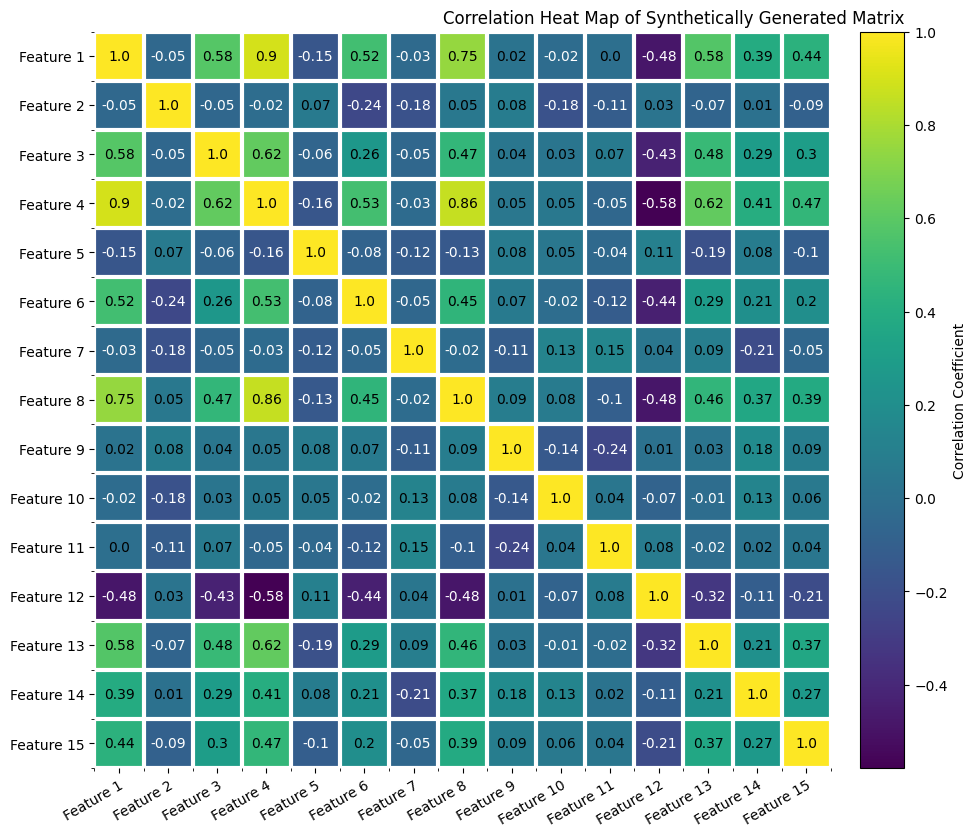

In [7]:
# Heatmap of original synthetic data
syn_corr_matrix = syn_X_1.corr()
heatmap(syn_corr_matrix, "Correlation Heat Map of Synthetically Generated Matrix")

Calculating the VIF scores for better multicollinearity understanding

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_syn_data = pd.DataFrame()
vif_syn_data['features']= syn_X_1.columns

vif_syn_data['VIF'] = [variance_inflation_factor(syn_X_1.values, i)
                       for i in range(len(syn_X_1.columns))]

vif_syn_data

,features,VIF
0,Feature 1,7.151192
1,Feature 2,1.233485
2,Feature 3,1.842305
3,Feature 4,4.457367
4,Feature 5,1.092084
5,Feature 6,1.719632
6,Feature 7,1.178862
7,Feature 8,6.353322
8,Feature 9,1.169187
9,Feature 10,1.186771


Quite Evidently, Feature 1, 4, 8 are highly correlated. 
But not all multicollinear features are evident. Only deeper analysis of the heat map will give an insight of multicollinearity. So for a very high dimensional data, VIF might not clearly project all the correlated data. 

Data Splitting of synthetic data: both original & normalised

In [9]:
# 80% data as train data 
train_ratio = 0.8

# original synthetic data splitting
X_syn_train, X_syn_test, y_syn_train, y_syn_test = tts(syn_X_1, syn_y, train_size =  train_ratio)

# normalising the synthetic data
scaler_x = stdscaler()
scaler_y = stdscaler()
X_syn_train_scaled = scaler_x.fit_transform(X_syn_train)
X_syn_test_scaled = scaler_x.transform(X_syn_test)
y_syn_train_scaled = scaler_y.fit_transform(y_syn_train)
y_syn_test_scaled = scaler_y.fit_transform(y_syn_test)

## Smart Farming Sensor Data for Yield Prediction Processing

In [10]:
# Loading smart farming sensor data for yield prediction
# fd : farmdata
# inputs => 
X_fd, y_fd, _ = data_loading_preprocessing("farm-yield-data")

Skipping, found downloaded files in "data\raw\smart-farming-sensor-data-for-yield-prediction" (use force=True to force download)


Extract the data description, check for:
missing values, nan values

In [11]:
X_fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   farm_id              500 non-null    object 
 1   region               500 non-null    object 
 2   crop_type            500 non-null    object 
 3   soil_moisture_%      500 non-null    float64
 4   soil_pH              500 non-null    float64
 5   temperature_C        500 non-null    float64
 6   rainfall_mm          500 non-null    float64
 7   humidity_%           500 non-null    float64
 8   sunlight_hours       500 non-null    float64
 9   irrigation_type      350 non-null    object 
 10  fertilizer_type      500 non-null    object 
 11  pesticide_usage_ml   500 non-null    float64
 12  sowing_date          500 non-null    object 
 13  harvest_date         500 non-null    object 
 14  total_days           500 non-null    int64  
 15  sensor_id            500 non-null    obj

irrigation_type & crop_disease_status have null values. \
The None values in irrigation_type & crop_disease_status,   mean that there is no irrigation & there is no diseases in the crop, respectively. So we can replace 'None' with 'No Irrigation' & 'No Disease', to prevent any NoneType errors\
We can drop farm_id, sensor_id, timestamp, harvest, sowing date( captureed in total_days) as they are not really required. 

Categorical Features are:
1. region
2. crop type
3. irrigation_type
4. fertilizer_type
5. crop_disease_status

In [12]:
X_fd_1 =  X_fd.copy()

# dropping farm_id, sensor_id, timestamp, harvest, sowing date
X_fd_1 = X_fd_1.drop(columns=['farm_id', 'sensor_id', 'timestamp', 'sowing_date', 'harvest_date'], axis=1)

# Replacing None values in irrigation_type to 'No Irrigation'
X_fd_1['irrigation_type'] = X_fd['irrigation_type'].apply(lambda x:'No Irrigation' if pd.isna(x) else x)

# Replacing None values in crop_disease_status to 'No Disease'
X_fd_1['crop_disease_status'] = X_fd['crop_disease_status'].apply(lambda x:'No Disease' if pd.isna(x) else x)

In [13]:
X_fd_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   region               500 non-null    object 
 1   crop_type            500 non-null    object 
 2   soil_moisture_%      500 non-null    float64
 3   soil_pH              500 non-null    float64
 4   temperature_C        500 non-null    float64
 5   rainfall_mm          500 non-null    float64
 6   humidity_%           500 non-null    float64
 7   sunlight_hours       500 non-null    float64
 8   irrigation_type      500 non-null    object 
 9   fertilizer_type      500 non-null    object 
 10  pesticide_usage_ml   500 non-null    float64
 11  total_days           500 non-null    int64  
 12  latitude             500 non-null    float64
 13  longitude            500 non-null    float64
 14  NDVI_index           500 non-null    float64
 15  crop_disease_status  500 non-null    obj

### Categorical Encoding
crop_disease_status => Ordinal Encoding\
region, crop_type, irrigation_type, fertilizer_type => one hot encoding

In [14]:
from sklearn.preprocessing import OrdinalEncoder as ode, OneHotEncoder as ohe

# ordinal encoder for crop_disease_status
ordinalencoder = ode(categories = [["No Disease", "Mild", "Moderate", "Severe"]])

# one hot encoding for other categorical values
onehotencoder = ohe(sparse_output = False)

# Ordinal Encoding
X_fd_1["ode_crop_disease_status"] = ordinalencoder.fit_transform(X_fd_1[['crop_disease_status']])

# One hot Encoding
ohe_columns = ['region',  'crop_type', 'irrigation_type', 'fertilizer_type']
ohe_data = onehotencoder.fit_transform(X_fd_1[ohe_columns])
ohe_region_names = onehotencoder.get_feature_names_out(ohe_columns)
X_fd_1[ohe_region_names] = ohe_data

# lets drop the original columns from the data
ohe_columns.insert(0, 'crop_disease_status')
X_fd_1 = X_fd_1.drop(columns=ohe_columns, axis=1)

In [15]:
X_fd_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   soil_moisture_%                500 non-null    float64
 1   soil_pH                        500 non-null    float64
 2   temperature_C                  500 non-null    float64
 3   rainfall_mm                    500 non-null    float64
 4   humidity_%                     500 non-null    float64
 5   sunlight_hours                 500 non-null    float64
 6   pesticide_usage_ml             500 non-null    float64
 7   total_days                     500 non-null    int64  
 8   latitude                       500 non-null    float64
 9   longitude                      500 non-null    float64
 10  NDVI_index                     500 non-null    float64
 11  ode_crop_disease_status        500 non-null    float64
 12  region_Central USA             500 non-null    flo

### Correlation Heatmaps

Plot saved successfully to: C:\random\Desktop\ResearchTopics\RS1\results/figures\Correlation-Heatmap-for-Smart-Farming-Sensor-Data-for-Yield-Prediction.png


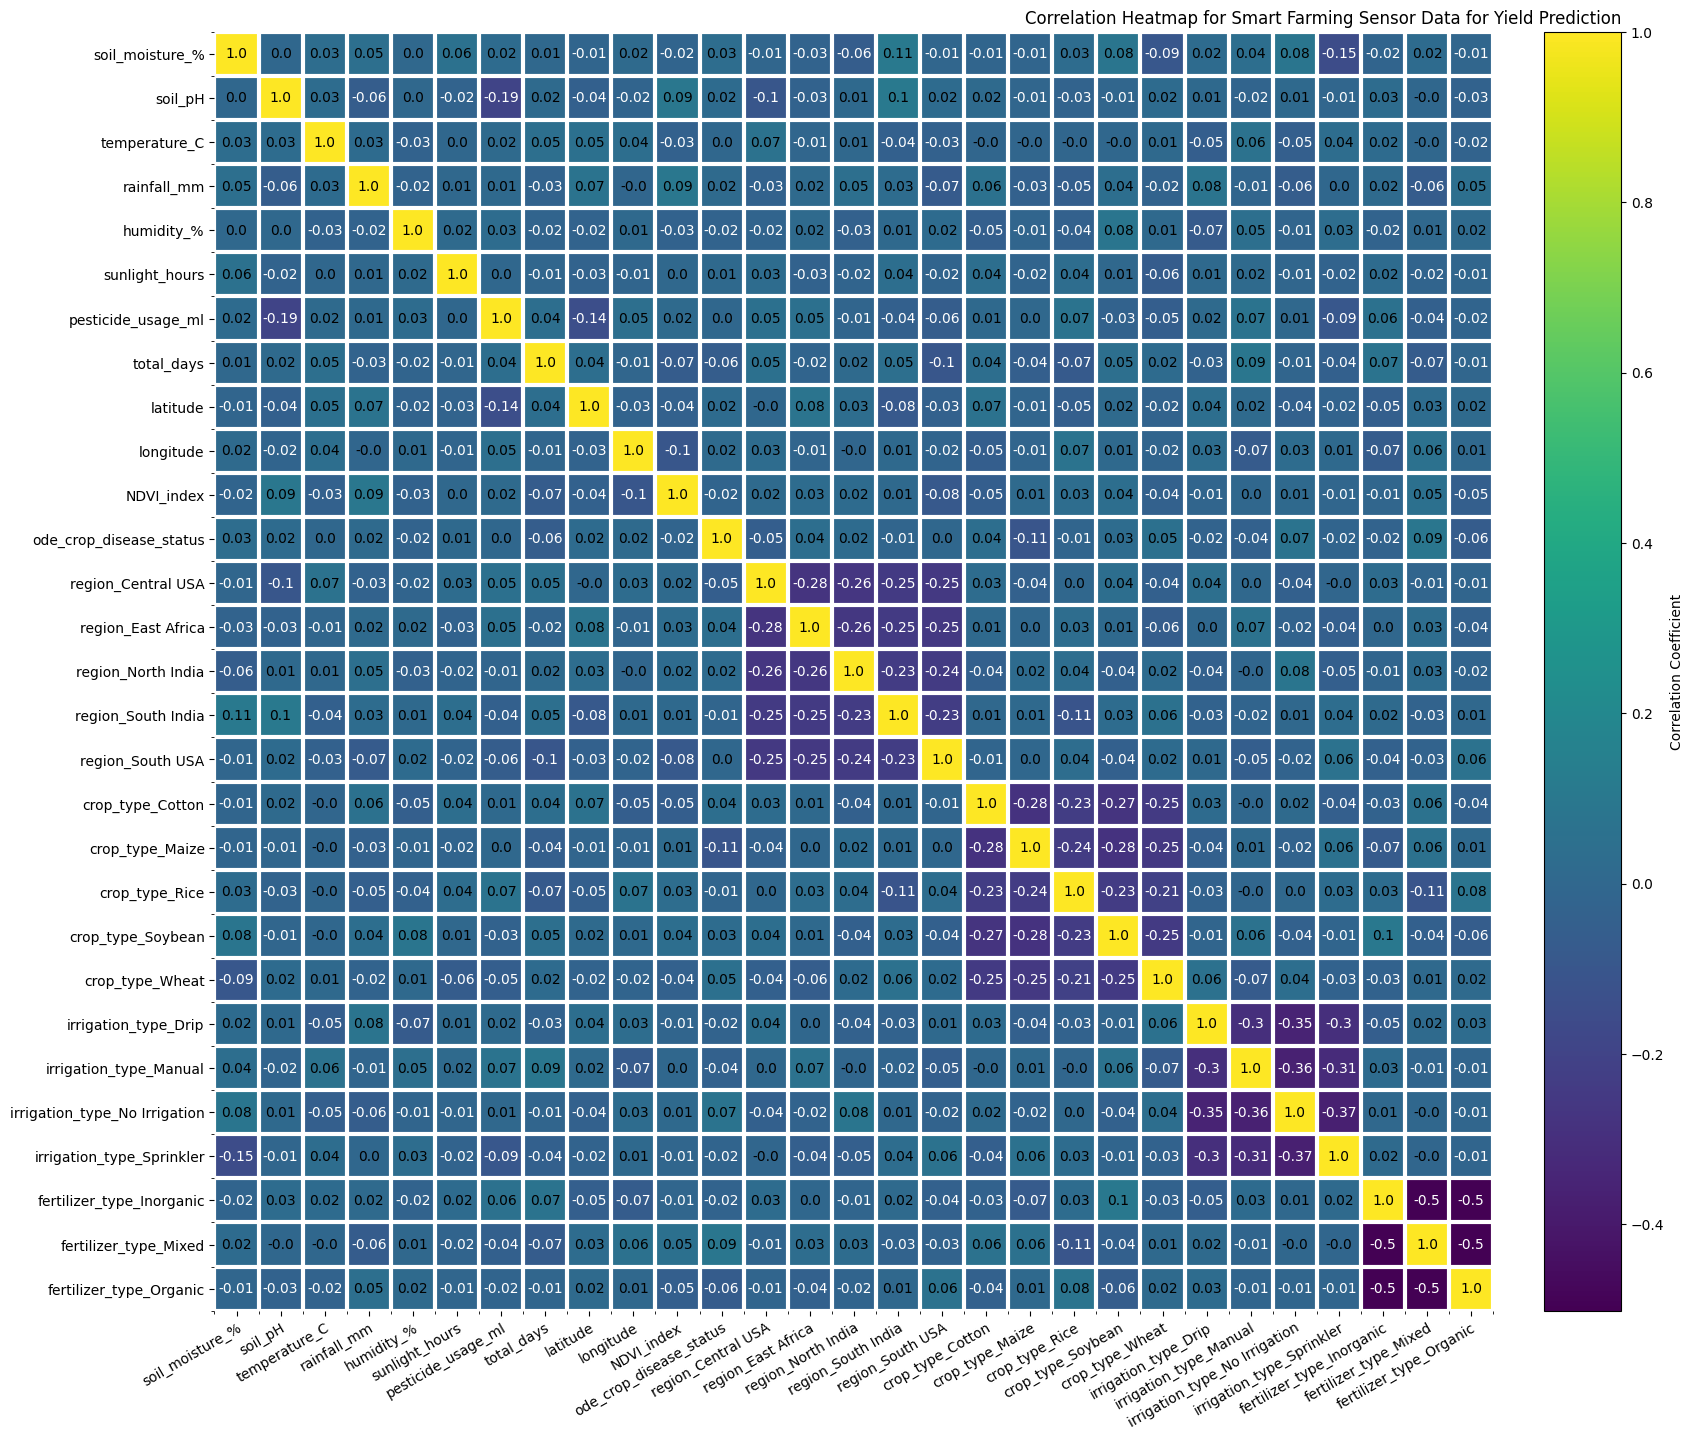

In [16]:
fd_corr_matrix = X_fd_1.corr()
heatmap(fd_corr_matrix, "Correlation Heatmap for Smart Farming Sensor Data for Yield Prediction", fig_size = (10, 10))



The squares along diagnol indicate the dummy variables created for each of the categorical values

### checking for VIF values

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_fd_data = pd.DataFrame()
vif_fd_data['features']= X_fd_1.columns

vif_fd_data['VIF'] = [variance_inflation_factor(X_fd_1.values, i)
                       for i in range(len(X_fd_1.columns))]

vif_fd_data

c:\random\Desktop\ResearchTopics\RS1\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF
0,soil_moisture_%,1.068843
1,soil_pH,1.085783
2,temperature_C,1.029456
3,rainfall_mm,1.055352
4,humidity_%,1.024372
5,sunlight_hours,1.015357
6,pesticide_usage_ml,1.104303
7,total_days,1.051573
8,latitude,1.063653
9,longitude,1.039234


VIF could not detect correlation of dummy variables of categorical variables

### Splitting Data for train & test set -> Later standardize

In [18]:
train_ratio = 0.8
X_fd_train, X_fd_test, y_fd_train, y_fd_test = tts(X_fd_1, y_fd, train_size=train_ratio)

In [19]:
print(X_fd_train.shape)
print(y_fd_train.shape)
print(X_fd_test.shape)
print(y_fd_test.shape)

(400, 29)
(400,)
(100, 29)
(100,)


#### Data Standardization of numerical features

In [20]:
scaler_x_fd = stdscaler()
scaler_y_fd = stdscaler()
X_fd_train_scaled = scaler_x_fd.fit_transform(X_fd_train)
X_fd_test_scaled = scaler_x_fd.transform(X_fd_test)
y_fd_train_scaled = scaler_y_fd.fit_transform(pd.DataFrame(y_fd_train))
y_fd_test_scaled = scaler_y_fd.fit_transform(pd.DataFrame(y_fd_test))

# Saving all data generated in the notebook along with the scalers

In [25]:
cwd = os.getcwd()
root_dir = os.path.dirname(cwd)

# Saving train , test data of synthetic data along with true_beta
data_dir = os.path.join(root_dir, "data/processed")

# Converting true_beta to a dataframe for easier saving
true_beta_df = pd.DataFrame(true_beta, columns = ["Coefficients"])
features = np.array(syn_X.columns)
true_beta_df['Features'] = pd.DataFrame(features)

filenames = ["X_syn_train.csv", "X_syn_test.csv", "y_syn_train.csv", "y_syn_test.csv", "Syn_true_beta.csv"]

syndfs = [X_syn_train_scaled, X_syn_test_scaled, y_syn_train_scaled, y_syn_test_Scaled, true_beta_df]
for i in range(len(filenames)):
    try:
        filepath = os.path.join(data_dir, filenames[i])
        syndfs[i].to_csv(filepath, index=False)
    except Exception as e:
        print("Error: ", e)
    
# Saving scaler_x & scaler_y
model_dir = os.path.join(root_dir, "models")
joblib.dump(scaler_x, os.path.join(model_dir, "scaler_x_syn.pkl"))
joblib.dump(scaler_y, os.path.join(model_dir, "scaler_y_syn.pkl"))

['C:\\random\\Desktop\\ResearchTopics\\RS1\\models\\scaler_y_syn.pkl']

In [30]:
cwd = os.getcwd()
root_dir = os.path.dirname(cwd)

# Saving train , test data of Farm Sensor data
data_dir = os.path.join(root_dir, "data/processed")

filenames = ["X_fd_train.csv", "X_fd_test.csv", "y_fd_train.csv", "y_fd_test.csv"]

fddfs = [pd.DataFrame(X_fd_train_scaled), pd.DataFrame(X_fd_test_scaled), pd.DataFrame(y_fd_train_scaled), pd.DataFrame(y_fd_test_scaled)]
for i in range(len(filenames)):
    try:
        filepath = os.path.join(data_dir, filenames[i])
        fddfs[i].to_csv(filepath, index=False)
    except Exception as e:
        print("Error: ", e)
    
# Saving scaler_x_fd & scaler_y_fd
model_dir = os.path.join(root_dir, "models")
joblib.dump(scaler_x_fd, os.path.join(model_dir, "scaler_x_fd.pkl"))
joblib.dump(scaler_y_fd, os.path.join(model_dir, "scaler_y_fd.pkl"))

['C:\\random\\Desktop\\ResearchTopics\\RS1\\models\\scaler_y_fd.pkl']